In [1]:
%run ../__init__.ipynb

In [2]:
interaction_id = 'P05106_P08514'
(uniprot_id1, uniprot_id2) = interaction_id.split('_')
r = suppl_ppi_models(pdockq=0).query('interaction_id == @interaction_id').squeeze()
r_pdb = workpath(f'23.12.06_ppi_reselect/af2-models-split/{r.pdb}')
r_pdb_local = os.path.join("~/work-euler/23.12.06_ppi_reselect/af2-models-split/", r.pdb)
print(r_pdb_local)

~/work-euler/23.12.06_ppi_reselect/af2-models-split/P05106/P05106_P08514.pdb


In [4]:
df_intact = read_intact_mutations().query('interaction_id == @interaction_id').rename({'effect': 'intact_effect'}, axis=1)[['variant_id', 'intact_effect']]
printlen(df_intact, 'IntAct mutations')
df_clinvar = read_clinvar().query('(Uniprot_id == @uniprot_id1 | (Uniprot_id == @uniprot_id2))')
printlen(df_clinvar, 'variants mapping to interaction')
df_var = df_intact.merge(df_clinvar, on='variant_id', how='outer')
printlen(df_var, 'variants after merge')
df_var = merge_missense(df_var, variant_col='variant_id').query('(intact_effect == intact_effect) | (am_class == "pathogenic")')
printlen(df_var, 'variants after selecting for pathogenic predictions')

df_var[['_uniprot_id', '_aa_pos', '_aa_ref', '_aa_alt']] = df_var.apply(lambda r: parse_varstr(r['variant_id']), axis=1, result_type='expand')
df_var = df_var.sort_values(['_uniprot_id', '_aa_pos', '_aa_alt',]).reset_index(drop=True)

read_intact_mutations: 78,139 IntAct mutations
read_intact_mutations: 78,119 with defined `Interaction participants`
read_intact_mutations: 70,031 with exactly two participants
read_intact_mutations: 70,031 after parsing participants
read_intact_mutations: 54,369 after filtering participant A for human
read_intact_mutations: 49,495 after filtering participant B for human
read_intact_mutations: 39,919 single-residue substititions
read_intact_mutations: 39,919 effects - neutral: 20042 disrupt/decrease: 16224 no data on effect: 2007 cause/increase: 1646
read_intact_mutations: 32,857 after de-duplication
7 IntAct mutations
read_clinvar: 1,857,854 rows from /cluster/work/beltrao/jjaenes/23.06.02_clinvar/24.04.22_protvar_out/clinvar_mapped.tsv
read_clinvar: 1,761,408 after removing conflicting/other variants
802 variants mapping to interaction
809 variants after merge
merge_missense: 809 raw records
merge_missense: 809 records matched to predictions
merge_missense: 220 annotated as destabili

In [5]:
@functools.cache
def get_struct(file):
    parser = Bio.PDB.PDBParser(QUIET=True)
    struct = parser.get_structure(file, file)[0]
    return struct

def get_struct_resid_dist(file, chain, pos, other_chain):
    try:
        struct = get_struct(file)
        for res in struct[chain].get_residues():
            if res.get_id()[1] == pos:
                return min(( calc_residue_dist_all(res, other_res) for other_res in struct[other_chain].get_residues() ))
    except AttributeError:
        return float('nan')

def get_dist(variant_id):
    uniprot_id, aa_pos, aa_ref, aa_alt = parse_varstr(variant_id)
    if uniprot_id == r.uniprot_id1:
        chain, other_chain = r.chain1, r.chain2
    elif uniprot_id == r.uniprot_id2:
        chain, other_chain = r.chain2, r.chain1
    return get_struct_resid_dist(r_pdb, chain, aa_pos, other_chain)

df_var['dist_to_other_chain'] = df_var['variant_id'].map(get_dist)

ValueError: Index contains duplicate entries, cannot reshape

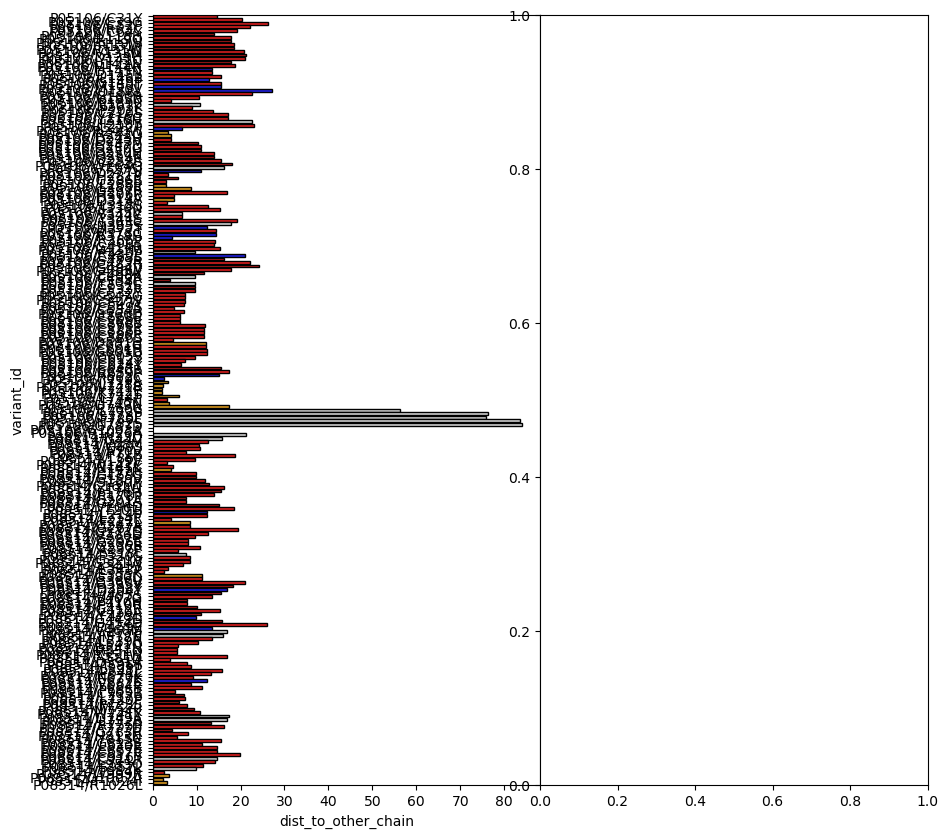

In [6]:
colors_ = {
    'Stability': matplotlib.colors.CSS4_COLORS['red'],
    'Interface': matplotlib.colors.CSS4_COLORS['orange'],
    'Pockets': matplotlib.colors.CSS4_COLORS['blue'],
    'Unassigned': matplotlib.colors.CSS4_COLORS['lightgrey'],
}
#https://stackoverflow.com/questions/65810567/aligning-subplots-with-a-pyplot-barplot-and-seaborn-heatmap
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))#, gridspec_kw={'width_ratios': [1, 1]})
plt.subplots_adjust(wspace=0)
sns.barplot(data=df_var, y='variant_id', x='dist_to_other_chain', palette=df_var['mechanistic_label'].map(colors_), edgecolor='0', ax=ax[0])
handles_ = [matplotlib.patches.Patch(color=v, label=k) for k, v in colors_.items()]
#ax[0].set_
#plt.legend(handles=handles_, title='Effect on interaction')
#plt.gca().invert_yaxis()
#plt.gca().set_xlabel(f'Distance from mutated residue to DUSP6')
#plt.gca().set_ylabel(f'Mutated residue on MAPK1')
#fp_ = 'P28482_Q16828.svg'
#plt.savefig(fp_, bbox_inches='tight', transparent=True)

df_annot = df_var.copy()
df_annot['CLNDN'] = df_annot['CLNDN'].str.split('|')
df_annot = df_annot.explode('CLNDN')
df_annot = df_annot.query('(CLNDN == CLNDN) & (CLNDN != "not_provided") & (CLNDN != "not_specified")')
df_annot['annotation_summary'] = df_annot['CLNDN'].map(lambda s: f'clinvar:{s}')
df_annot['annotation_summary'].value_counts()

df_ = df_annot[['variant_id', 'annotation_summary']].copy()
df_['isin'] = True
df_clustermap_ = df_.pivot(index=['variant_id'], columns='annotation_summary', values='isin').fillna(False).reset_index().set_index('variant_id')
df_right_ = (df_var.set_index('variant_id')[['intact_effect']] == 'disrupt/decrease')\
    .merge(df_clustermap_, left_index=True, right_index=True, how='left').fillna(False)
#.merge(df_var.set_index('variant_id')[['intact_effect']] == 'neutral', left_index=True, right_index=True)\
sns.heatmap(df_right_, ax=ax[1], yticklabels=False, annot=False, linewidths=0.01)
#ax[1].xaxis.tick_top()
#plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=80);

In [ ]:
cmd_ = []
cmd_.append(f'load {r_pdb_local} , {r.interaction_id}')
cmd_.append(f'color tab_gray, {r.interaction_id} & chain {r.chain1}')
cmd_.append(f'color tab_brown, {r.interaction_id} & chain {r.chain2}')
print('\n'.join(cmd_))

In [ ]:
df_clinvar = read_clinvar(nrows=None).query('clinvar_label == "Pathogenic" | clinvar_label == "VUS"').copy().rename({'variant_id': 'protein_variant'}, axis=1)
df_clinvar

In [ ]:
uniprot_id = 'P28482'
df_annot = merge_missense(df_clinvar.query('Uniprot_id == @uniprot_id').copy(), variant_col='protein_variant')

In [ ]:
df_annot['CLNDN'] = df_annot['CLNDN'].str.split('|')
df_annot = df_annot.explode('CLNDN')
df_annot = df_annot.query('(CLNDN != "not_provided") & (CLNDN != "not_specified")')
df_annot['annotation_summary'] = df_annot['CLNDN'].map(lambda s: f'clinvar:{s}')
df_annot['annotation_summary'].value_counts()

In [ ]:
#pd.get_dummies(df_annot[['protein_variant', 'annotation_summary']], prefix_sep='_is_', columns=['annotation_summary'], dtype=bool)
df_ = df_annot[['protein_variant', 'annotation_summary', 'mechanistic_label', 'clinvar_label']].copy()
df_['isin'] = True
df_clustermap_ = df_.pivot(index=['protein_variant', 'mechanistic_label', 'clinvar_label'], columns='annotation_summary', values='isin').fillna(False).reset_index().set_index('protein_variant')
df_clustermap_

In [ ]:
col_clinvar_label_ = {
    'Benign': matplotlib.colors.CSS4_COLORS['blue'],
    'VUS': matplotlib.colors.CSS4_COLORS['orange'],
    'Pathogenic': matplotlib.colors.CSS4_COLORS['red'],
}

col_mechanistic_label_ = {
    'Stability': matplotlib.colors.CSS4_COLORS['blue'],
    'Interface': matplotlib.colors.CSS4_COLORS['orange'],
    'Pockets': matplotlib.colors.CSS4_COLORS['blue'],
    'Unassigned': matplotlib.colors.CSS4_COLORS['lightgrey'],
}

cg = sns.clustermap(
    figsize=(8,8),
    data=df_clustermap_.drop(['mechanistic_label', 'clinvar_label'], axis=1),
    row_colors=[
        df_clustermap_['clinvar_label'].map(col_clinvar_label_),
        df_clustermap_['mechanistic_label'].map(col_mechanistic_label_),
    ],
    method='average', metric='jaccard',
    linewidths=0.1,
)
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=80);